In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pickle

Datensatz laden

In [2]:
play_data = pd.read_csv(
    'data_final.1.csv'
)

Aufteilung in Trainings-, Validierungs- und Testdatensatz

In [3]:
unique_game_ids = play_data['GameID'].unique()

train_game_ids, remaining_game_ids = train_test_split(unique_game_ids, test_size=0.2, random_state=42)
train_game_ids, valid_game_ids = train_test_split(train_game_ids, test_size=0.2, random_state=42)
test_game_ids =remaining_game_ids


train_df = play_data[play_data['GameID'].isin(train_game_ids)]
valid_df = play_data[play_data['GameID'].isin(valid_game_ids)]
test_df = play_data[play_data['GameID'].isin(test_game_ids)]

In [4]:
train_game_ids = set(train_df['GameID'])
valid_game_ids = set(valid_df['GameID'])
test_game_ids = set(test_df['GameID'])

intersection_train_valid = train_game_ids.intersection(valid_game_ids)
intersection_train_test = train_game_ids.intersection(test_game_ids)
intersection_valid_test = valid_game_ids.intersection(test_game_ids)

if len(intersection_train_valid) == 0 and len(intersection_train_test) == 0 and len(intersection_valid_test) == 0:
    print("Keine gemeinsamen GameIDs zwischen train_df, valid_df und test_df.")
else:
    print("Es gibt gemeinsame GameIDs zwischen train_df, valid_df und test_df.")

Keine gemeinsamen GameIDs zwischen train_df, valid_df und test_df.


Laden des XGBoost-Modells

In [ ]:
#Es kann auch der Random Forest zur Anwendung angwendet werden, hierzu muss der Code unten angepasst werden
#rf_filename = "RandomForest_final.pkl"
#with open(rf_filename, 'rb') as file:
    #rf_model = pickle.load(file)

In [5]:
xgb_filename = "/Users/michelbauer/Downloads/xgbAll_final.pkl"
with open(xgb_filename, 'rb') as file:
    xgb_model = pickle.load(file)

In [6]:
y_train_xgb = train_df['Winner']
y_valid_xgb = valid_df['Winner']
y_test_xgb = test_df['Winner']
X_train_xgb = train_df.drop('Winner', axis=1)
X_valid_xgb = valid_df.drop('Winner', axis=1)
X_test_xgb = test_df.drop('Winner', axis=1)


y_valid_xgb = y_valid_xgb.astype(int)
y_train_xgb = y_train_xgb.astype(int)
y_test_xgb = y_test_xgb.astype(int)
cardinality_cols = ['GameID','type_text', 'team_play', 'start_down', 'end_down', 'season', 'week', 'Home_teamname', 'Away_teamname', 'leading_Team']
numerical_cols = ['scoring_game','point_difference','awayScore', 'homeScore', 'scoreValue', 'statYardage', 'quarter', 'clock', 'start_distance', 'start_yardlinie', 'start_yardsToEndzone', 'end_distance', 'end_yardlinie', 'end_yardsToEndzone', 'elo_score_away', 'elo_score_home', 'attendence', 'time_remaining']


scaler = StandardScaler()
X_train_numerical_xgb = scaler.fit_transform(X_train_xgb[numerical_cols])
X_valid_numerical_xgb = scaler.transform(X_valid_xgb[numerical_cols])
X_test_numerical_xgb = scaler.transform(X_test_xgb[numerical_cols])

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_categorical_xgb = encoder.fit_transform(X_train_xgb[cardinality_cols]).toarray()
X_valid_categorical_xgb = encoder.transform(X_valid_xgb[cardinality_cols]).toarray()
X_test_categorical_xgb = encoder.transform(X_test_xgb[cardinality_cols]).toarray()


X_train_processed_xgb = np.concatenate([X_train_numerical_xgb, X_train_categorical_xgb], axis=1)
X_valid_processed_xgb = np.concatenate([X_valid_numerical_xgb, X_valid_categorical_xgb], axis=1)
X_test_processed_xgb = np.concatenate([X_test_numerical_xgb, X_test_categorical_xgb], axis=1)

In [7]:
preds_test_xgb = xgb_model.predict(X_test_processed_xgb)


accuracy_test_xgb = accuracy_score(y_test_xgb, preds_test_xgb)
precision_test_xgb = precision_score(y_test_xgb, preds_test_xgb)
recall_test_xgb = recall_score(y_test_xgb, preds_test_xgb)
f1_test_xgb = f1_score(y_test_xgb, preds_test_xgb)
auc_test_xgb = roc_auc_score(y_test_xgb, preds_test_xgb)
cm_test_xgb = confusion_matrix(y_test_xgb, preds_test_xgb)
cm_str_test_xgb = np.array2string(cm_test_xgb, separator=', ')


print("\nTest Set Metrics:")
print("Accuracy:", accuracy_test_xgb)
print("Precision:", precision_test_xgb)
print("Recall:", recall_test_xgb)
print("F1 Score:", f1_test_xgb)
print("AUC:", auc_test_xgb)
print("Confusion Matrix:\n", cm_str_test_xgb)


Test Set Metrics:
Accuracy: 0.7438023533400195
Precision: 0.7373444651440926
Recall: 0.8267742933773468
F1 Score: 0.7795027657893138
AUC: 0.7350443912774856
Confusion Matrix:
 [[20597, 11420],
 [ 6717, 32059]]


Das XGBoost Modell anwenden

In [8]:
data = pd.concat([X_train_xgb, X_valid_xgb,X_test_xgb], ignore_index=True)

In [9]:
data=data.reset_index(drop=True)

In [10]:
data_processed=np.concatenate((X_train_processed_xgb, X_valid_processed_xgb, X_test_processed_xgb), axis=0)

In [11]:
preds_wshl_xgb= xgb_model.predict_proba(data_processed)

In [13]:
preds_game=preds_wshl_xgb[(data['GameID']==	401437834)]

In [14]:
data[(data['GameID']==401437834)]

,GameID,playID,awayScore,homeScore,scoreValue,statYardage,quarter,clock,type_text,team_play,...,week,Home_teamname,Away_teamname,elo_score_away,elo_score_home,attendence,time_remaining,leading_Team,point_difference,scoring_game
216225,401437834,40143783441,0,0,0,0,1,15.000000,Kickoff,det,...,10,chi,det,1404.406,1431.96,1.005154,60.000000,tie,0.0,1
216226,401437834,40143783456,0,0,0,28,1,15.000000,Rush,chi,...,10,chi,det,1404.406,1431.96,1.005154,60.000000,tie,0.0,1
216227,401437834,40143783482,0,0,0,9,1,14.450000,Rush,chi,...,10,chi,det,1404.406,1431.96,1.005154,59.450000,tie,0.0,1
216228,401437834,401437834103,0,0,0,13,1,13.766667,Rush,chi,...,10,chi,det,1404.406,1431.96,1.005154,58.766667,tie,0.0,1
216229,401437834,401437834129,0,0,0,10,1,13.133333,Rush,chi,...,10,chi,det,1404.406,1431.96,1.005154,58.133333,tie,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216390,401437834,4014378343793,31,30,0,-3,4,0.983333,Rush,det,...,10,chi,det,1404.406,1431.96,1.005154,0.983333,det,1.0,1
216391,401437834,4014378343816,31,30,0,0,4,0.933333,Timeout,det,...,10,chi,det,1404.406,1431.96,1.005154,0.933333,det,1.0,1
216392,401437834,4014378343823,31,30,0,7,4,0.933333,Rush,det,...,10,chi,det,1404.406,1431.96,1.005154,0.933333,det,1.0,1
216393,401437834,4014378343846,31,30,0,-1,4,0.266667,Rush,det,...,10,chi,det,1404.406,1431.96,1.005154,0.266667,det,1.0,1


Die Gewinnwahrscheinlichkeiten während des Spiles plotten

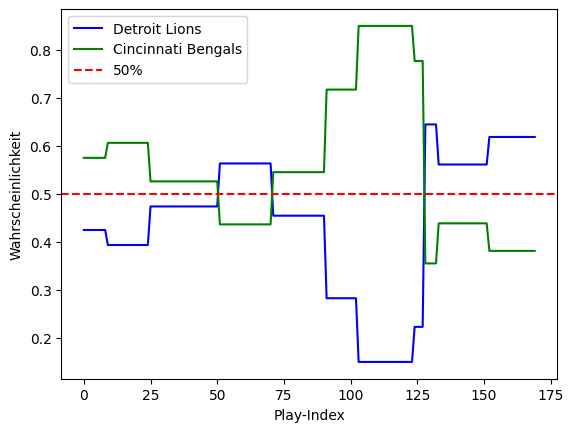

In [15]:
AwayTeam = preds_game[:,0]  
HomeTeam= preds_game[:,1]  


plt.plot(AwayTeam, color='blue', label='Detroit Lions')
plt.plot(HomeTeam, color='green', label='Cincinnati Bengals')
plt.axhline(y=0.5, color='red', linestyle='--', label='50%')


plt.xlabel('Play-Index')
plt.ylabel('Wahrscheinlichkeit')


plt.legend()


plt.show()

Hier werden die wichtigesten Plays des Spiels Cincinnati Bengals vs. Detroit Lions herausgefilter

In [54]:

preds_game=preds_wshl_xgb[(data['GameID']==	401437834)]
game= data[data['GameID']==401437834].reset_index(drop=True)

for proba in range(len(preds_game)-1):
        wshl = abs(preds_game[:,0][proba+1]-preds_game[:,0][proba])
        if wshl>0 :
            print(wshl)
            print(proba+1)
            print(preds_game[:,0][proba+1])
            print(preds_game[:,1][proba+1])
            print(game.iloc[proba+1])
            
        

0.03125918
9
0.39367878
0.6063212
GameID                        401437834
playID                     401437834251
awayScore                             0
homeScore                             3
scoreValue                            3
statYardage                          33
quarter                               1
clock                             10.65
type_text               Field Goal Good
team_play                           chi
start_down                            4
start_distance                       10
start_yardlinie                      85
start_yardsToEndzone                 15
end_down                             -1
end_distance                         10
end_yardlinie                       100
end_yardsToEndzone                   65
season                             2022
week                                 10
Home_teamname                       chi
Away_teamname                       det
elo_score_away                 1404.406
elo_score_home                  1431.96
attend

Hier wird der beste 'Pass Reception' Spielzug der Saison 2022 gesucht

In [21]:
season_2022 = data[(data['season']==2022)]

In [25]:

for Game in season_2022['GameID'].unique():
    preds_game = preds_wshl_xgb[(data['GameID']==Game)]
    season_2022_reindex_game = season_2022[season_2022['GameID']==Game].reset_index(drop=True)
    for proba in range(len(preds_game)-1):
        wshl1 = abs(preds_game[:,0][proba+1]-preds_game[:,0][proba])
        if season_2022_reindex_game.iloc[proba+1]['type_text']=='Pass Reception' and wshl1>0:
            print(wshl1)
            print(season_2022_reindex_game.iloc[proba+1])
            
       
    

0.07297486
GameID                       401437735
playID                   4014377354183
awayScore                           17
homeScore                           29
scoreValue                           6
statYardage                          0
quarter                              4
clock                              0.0
type_text               Pass Reception
team_play                          pit
start_down                           1
start_distance                      10
start_yardlinie                     96
start_yardsToEndzone                96
end_down                            -1
end_distance                        10
end_yardlinie                      100
end_yardsToEndzone                  15
season                            2022
week                                 3
Home_teamname                      cle
Away_teamname                      pit
elo_score_away                 1511.81
elo_score_home                 1504.49
attendence                         1.0
time_remaining